In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
import shutil
import time
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
base_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Metal: 790 images
Glass: 420 images
Paper: 500 images
Vegetation: 436 images
Cardboard: 461 images
Textile Trash: 318 images
Food Organics: 411 images
Plastic: 921 images
Miscellaneous Trash: 495 images


In [4]:
# Configuration
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
DATA_DIR = "/kaggle/input/realwaste/realwaste-main/RealWaste"

In [5]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [6]:
import splitfolders

input_folder = base_dir
split_dir = "/kaggle/working/RealWaste_split"

splitfolders.ratio(input_folder, output=split_dir, seed=42, ratio=(.7, .15, .15))

Copying files: 4752 files [00:59, 80.30 files/s]


In [7]:
# Count images in each subfolder
for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dir, split)
    print(f"\n{split.upper()} SET")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))

        total += count
        print(f"  {cls}: {count} images")
    print(f" Total {split}: {total} images")


TRAIN SET
  Vegetation: 305 images
  Metal: 553 images
  Glass: 294 images
  Cardboard: 322 images
  Plastic: 644 images
  Textile Trash: 222 images
  Paper: 350 images
  Food Organics: 287 images
  Miscellaneous Trash: 346 images
 Total train: 3323 images

VAL SET
  Vegetation: 65 images
  Metal: 118 images
  Glass: 63 images
  Cardboard: 69 images
  Plastic: 138 images
  Textile Trash: 47 images
  Paper: 75 images
  Food Organics: 61 images
  Miscellaneous Trash: 74 images
 Total val: 710 images

TEST SET
  Vegetation: 66 images
  Metal: 119 images
  Glass: 63 images
  Cardboard: 70 images
  Plastic: 139 images
  Textile Trash: 49 images
  Paper: 75 images
  Food Organics: 63 images
  Miscellaneous Trash: 75 images
 Total test: 719 images


In [8]:
# Data Augmentation
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=45),
        transforms.RandomResizedCrop(size=IMG_SIZE[0], scale=(0.6, 0.9)),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/kaggle/working/RealWaste_split/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("/kaggle/working/RealWaste_split/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder("/kaggle/working/RealWaste_split/test", transform=val_test_transforms)

# Get number of classes and device
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")

Using device: cuda
Number of classes: 9


In [9]:
# Increase the number of training data
duplication_factor = 3
train_dataset_augmented = ConcatDataset([train_dataset] * duplication_factor)

In [10]:
# Extract targets
targets = []
for dataset in train_dataset_augmented.datasets:  # train_dataset_augmented.datasets is a list
    if hasattr(dataset, 'targets'):
        targets.extend(dataset.targets)
    else:
        # fallback if custom dataset
        for i in range(len(dataset)):
            _, label = dataset[i]
            targets.append(label)

# Convert to numpy
targets = np.array(targets)

# Class counts
class_counts = np.bincount(targets)
print("Class counts:", class_counts)

base_dataset = train_dataset_augmented.datasets[0]  # first dataset in the concat list
classes = base_dataset.classes

# Compute class weights (inverse of frequency)
class_weights = 1. / class_counts

# Ensure sample_weights are floats for the sampler
sample_weights = [class_weights[label].item() for label in targets]

print("Class counts per category:")
for cls, count in zip(classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\n Class weights (inverse of frequency):")
for cls, w in zip(classes, class_weights):
    print(f"  {cls:15s}: {w:.6f}")

Class counts: [ 966  861  882 1659 1038 1050 1932  666  915]
Class counts per category:
  Cardboard      : 966
  Food Organics  : 861
  Glass          : 882
  Metal          : 1659
  Miscellaneous Trash: 1038
  Paper          : 1050
  Plastic        : 1932
  Textile Trash  : 666
  Vegetation     : 915

 Class weights (inverse of frequency):
  Cardboard      : 0.001035
  Food Organics  : 0.001161
  Glass          : 0.001134
  Metal          : 0.000603
  Miscellaneous Trash: 0.000963
  Paper          : 0.000952
  Plastic        : 0.000518
  Textile Trash  : 0.001502
  Vegetation     : 0.001093


In [11]:
# Define a consistent BATCH_SIZE
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


print(f"\n WeightedRandomSampler created successfully!")
print(f" Total samples in epoch: {len(sample_weights)}")
print(f" Training Batch size: {train_loader.batch_size}")
print(f" Validation Batch size: {val_loader.batch_size}")
print(f" Total training batches per epoch: {len(train_loader)}")


 WeightedRandomSampler created successfully!
 Total samples in epoch: 9969
 Training Batch size: 32
 Validation Batch size: 32
 Total training batches per epoch: 312


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
    
        # TRAIN LOOP WITH PROGRESS BAR
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() * images.size(0)
    
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            train_loop.set_postfix(loss=loss.item(), acc=train_acc)
    
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # VALIDATION LOOP WITH PROGRESS BAR
        model.eval()
        val_running_loss = 0
        val_correct = 0
        val_total = 0
    
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                val_running_loss += loss.item() * images.size(0)
    
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Summary
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()

        # Convolution Blocks
        self.conv_block1 = self._create_conv_block(3, 64)  # 64 filtri
        self.conv_block2 = self._create_conv_block(64, 128)  # 128 filtri
        self.conv_block3 = self._create_conv_block(128, 256)  # 256 filtri
        self.conv_block4 = self._create_conv_block(256, 512)  # 512 filtri
        self.conv_block5 = self._create_conv_block(512, 512)  # 512 filtri aggiuntivi

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def _create_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = CNNModel(num_classes=9)
model_name = "Custom CNN"

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loss Function
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

model = model.to(device)

results = {}

def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

Using device: cuda


In [14]:
print(f"\n===== Training with Adam =====\n")

reset_weights(model)

# Adams Optimizer 
learning_rate = 1e-5
weight_decay = 1e-2
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Scheduler of learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20

# Training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
results['Adam'] = (train_losses, val_losses, train_accuracies, val_accuracies)

model_save_path = f"/kaggle/working/trained_{model_name}_adam.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


===== Training with Adam =====



Epoch 1/20: Train Loss: 1.5228, Train Acc: 45.38% | Val Loss: 1.2959, Val Acc: 55.77%


Epoch 2/20: Train Loss: 1.1325, Train Acc: 60.55% | Val Loss: 1.1052, Val Acc: 60.85%


Epoch 3/20: Train Loss: 0.9736, Train Acc: 65.95% | Val Loss: 0.9892, Val Acc: 63.52%


Epoch 4/20: Train Loss: 0.8617, Train Acc: 69.65% | Val Loss: 0.9116, Val Acc: 68.59%


Epoch 5/20: Train Loss: 0.7832, Train Acc: 71.88% | Val Loss: 0.8635, Val Acc: 70.42%


Epoch 6/20: Train Loss: 0.7183, Train Acc: 73.97% | Val Loss: 0.7742, Val Acc: 73.10%


Epoch 7/20: Train Loss: 0.6772, Train Acc: 75.79% | Val Loss: 0.7459, Val Acc: 74.51%


Epoch 8/20: Train Loss: 0.6322, Train Acc: 77.21% | Val Loss: 0.7587, Val Acc: 74.37%


Epoch 9/20: Train Loss: 0.5921, Train Acc: 78.27% | Val Loss: 0.7087, Val Acc: 73.94%


Epoch 10/20: Train Loss: 0.5578, Train Acc: 79.79% | Val Loss: 0.6568, Val Acc: 76.76%


Epoch 11/20: Train Loss: 0.5210, Train Acc: 80.87% | Val Loss: 0.7798, Val Acc: 71.83%


Epoch 12/20: Train Loss: 0.4960, Train Acc: 81.67% | Val Loss: 0.6092, Val Acc: 77.46%


Epoch 13/20: Train Loss: 0.4579, Train Acc: 83.74% | Val Loss: 0.6227, Val Acc: 77.46%


Epoch 14/20: Train Loss: 0.4349, Train Acc: 84.18% | Val Loss: 0.6210, Val Acc: 77.04%


Epoch 15/20: Train Loss: 0.4235, Train Acc: 84.76% | Val Loss: 0.5620, Val Acc: 80.56%


Epoch 16/20: Train Loss: 0.3938, Train Acc: 86.10% | Val Loss: 0.6401, Val Acc: 76.90%


Epoch 17/20: Train Loss: 0.3783, Train Acc: 86.59% | Val Loss: 0.5742, Val Acc: 80.85%


Epoch 18/20: Train Loss: 0.3619, Train Acc: 87.02% | Val Loss: 0.6775, Val Acc: 75.49%


Epoch 19/20: Train Loss: 0.3363, Train Acc: 88.06% | Val Loss: 0.5191, Val Acc: 80.99%


Epoch 20/20: Train Loss: 0.3294, Train Acc: 87.90% | Val Loss: 0.4657, Val Acc: 83.24%
Model saved to /kaggle/working/trained_Custom CNN_adam.pth


In [15]:
print(f"\n===== Training with SGD =====\n")

reset_weights(model)

# SGD Optimizer 
learning_rate = 1e-3
weight_decay = 1e-4
optimizer = optim.SGD(
    model.parameters(), 
    lr= learning_rate, 
    weight_decay= weight_decay
)

# Scheduler of learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20

# Training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
results['SGD'] = (train_losses, val_losses, train_accuracies, val_accuracies)

model_save_path = f"/kaggle/working/trained_{model_name}_sgd.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


===== Training with SGD =====



Epoch 1/20: Train Loss: 1.4535, Train Acc: 66.12% | Val Loss: 1.2484, Val Acc: 62.39%


Epoch 2/20: Train Loss: 0.8362, Train Acc: 80.52% | Val Loss: 0.8217, Val Acc: 77.32%


Epoch 3/20: Train Loss: 0.6248, Train Acc: 83.39% | Val Loss: 1.0824, Val Acc: 65.07%


Epoch 4/20: Train Loss: 0.5225, Train Acc: 85.63% | Val Loss: 1.2026, Val Acc: 59.01%


Epoch 5/20: Train Loss: 0.4633, Train Acc: 86.03% | Val Loss: 0.7576, Val Acc: 74.79%


Epoch 6/20: Train Loss: 0.4227, Train Acc: 87.04% | Val Loss: 0.7454, Val Acc: 76.76%


Epoch 7/20: Train Loss: 0.3905, Train Acc: 87.53% | Val Loss: 0.7903, Val Acc: 71.41%


Epoch 8/20: Train Loss: 0.3661, Train Acc: 88.17% | Val Loss: 1.4942, Val Acc: 54.08%


Epoch 9/20: Train Loss: 0.3550, Train Acc: 88.44% | Val Loss: 1.0096, Val Acc: 64.08%


Epoch 10/20: Train Loss: 0.3339, Train Acc: 88.81% | Val Loss: 0.9093, Val Acc: 72.96%


Epoch 11/20: Train Loss: 0.3267, Train Acc: 88.85% | Val Loss: 0.5785, Val Acc: 78.87%


Epoch 12/20: Train Loss: 0.3148, Train Acc: 89.18% | Val Loss: 0.5233, Val Acc: 81.41%


Epoch 13/20: Train Loss: 0.2892, Train Acc: 90.16% | Val Loss: 0.7101, Val Acc: 76.48%


Epoch 14/20: Train Loss: 0.2779, Train Acc: 90.59% | Val Loss: 0.6315, Val Acc: 77.32%


Epoch 15/20: Train Loss: 0.2684, Train Acc: 90.64% | Val Loss: 0.6961, Val Acc: 77.04%


Epoch 16/20: Train Loss: 0.2635, Train Acc: 90.92% | Val Loss: 0.6536, Val Acc: 78.03%


Epoch 17/20: Train Loss: 0.2554, Train Acc: 91.25% | Val Loss: 0.5111, Val Acc: 81.97%


Epoch 18/20: Train Loss: 0.2589, Train Acc: 90.94% | Val Loss: 0.5735, Val Acc: 79.15%


Epoch 19/20: Train Loss: 0.2412, Train Acc: 91.49% | Val Loss: 0.7024, Val Acc: 77.32%


Epoch 20/20: Train Loss: 0.2257, Train Acc: 92.18% | Val Loss: 0.6758, Val Acc: 78.31%
Model saved to /kaggle/working/trained_Custom CNN_sgd.pth


In [16]:
print(f"\n===== Training with SGD with Momentum =====\n")

reset_weights(model)

# SGD with Momentum Optimizer 
learning_rate = 1e-4
weight_decay = 1e-4
optimizer = optim.SGD(
    model.parameters(), 
    lr= learning_rate, 
    weight_decay= weight_decay,
    momentum=0.8
)

# Scheduler of learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20

# Training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
results['SGD with Momentum'] = (train_losses, val_losses, train_accuracies, val_accuracies)

model_save_path = f"/kaggle/working/trained_{model_name}_sgdmomentum.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


===== Training with SGD with Momentum =====



Epoch 1/20: Train Loss: 1.6967, Train Acc: 62.83% | Val Loss: 1.3442, Val Acc: 77.75%


Epoch 2/20: Train Loss: 1.0727, Train Acc: 83.13% | Val Loss: 0.9604, Val Acc: 80.85%


Epoch 3/20: Train Loss: 0.7774, Train Acc: 87.05% | Val Loss: 0.7790, Val Acc: 81.41%


Epoch 4/20: Train Loss: 0.6062, Train Acc: 89.19% | Val Loss: 0.6800, Val Acc: 81.97%


Epoch 5/20: Train Loss: 0.5024, Train Acc: 90.92% | Val Loss: 0.5992, Val Acc: 83.52%


Epoch 6/20: Train Loss: 0.4276, Train Acc: 91.66% | Val Loss: 0.5846, Val Acc: 81.27%


Epoch 7/20: Train Loss: 0.3816, Train Acc: 92.33% | Val Loss: 0.4924, Val Acc: 85.49%


Epoch 8/20: Train Loss: 0.3404, Train Acc: 92.96% | Val Loss: 0.4640, Val Acc: 87.18%


Epoch 9/20: Train Loss: 0.3146, Train Acc: 92.53% | Val Loss: 0.4882, Val Acc: 85.21%


Epoch 10/20: Train Loss: 0.2824, Train Acc: 93.71% | Val Loss: 0.4505, Val Acc: 86.34%


Epoch 11/20: Train Loss: 0.2659, Train Acc: 93.66% | Val Loss: 0.4599, Val Acc: 85.21%


Epoch 12/20: Train Loss: 0.2507, Train Acc: 94.16% | Val Loss: 0.4226, Val Acc: 87.04%


Epoch 13/20: Train Loss: 0.2365, Train Acc: 94.25% | Val Loss: 0.4227, Val Acc: 85.77%


Epoch 14/20: Train Loss: 0.2182, Train Acc: 94.79% | Val Loss: 0.4020, Val Acc: 86.90%


Epoch 15/20: Train Loss: 0.2072, Train Acc: 95.18% | Val Loss: 0.3689, Val Acc: 87.61%


Epoch 16/20: Train Loss: 0.2046, Train Acc: 94.73% | Val Loss: 0.4343, Val Acc: 85.77%


Epoch 17/20: Train Loss: 0.1928, Train Acc: 95.10% | Val Loss: 0.3858, Val Acc: 88.03%


Epoch 18/20: Train Loss: 0.1895, Train Acc: 94.75% | Val Loss: 0.4579, Val Acc: 82.96%


Epoch 19/20: Train Loss: 0.1797, Train Acc: 95.20% | Val Loss: 0.3913, Val Acc: 86.62%


Epoch 20/20: Train Loss: 0.1758, Train Acc: 95.28% | Val Loss: 0.3729, Val Acc: 87.04%
Model saved to /kaggle/working/trained_Custom CNN_sgdmomentum.pth


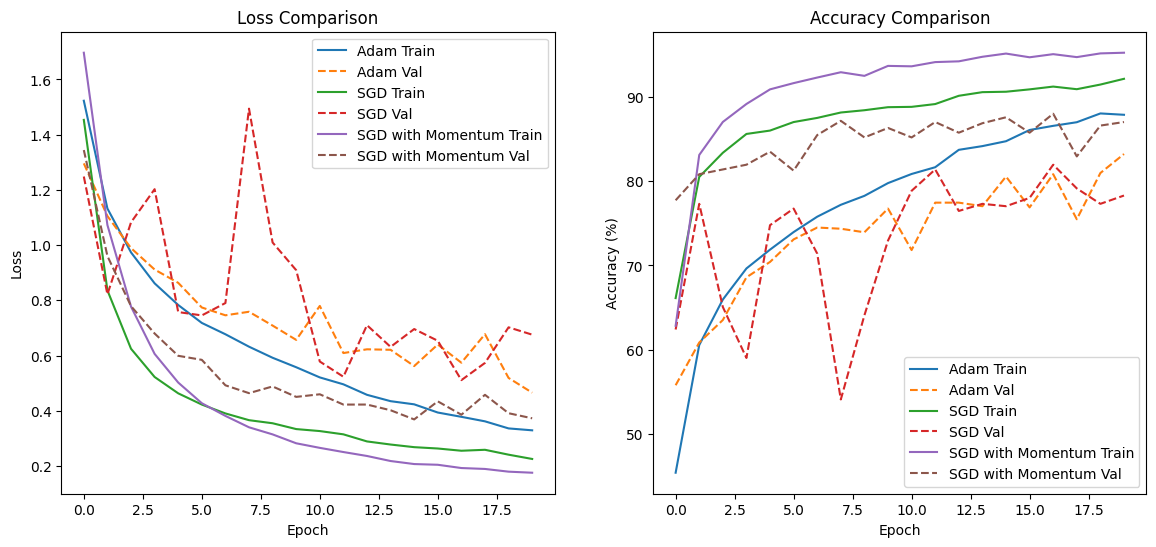

In [17]:
plt.figure(figsize=(14,6))

# Loss comparison
plt.subplot(1,2,1)
for name in results:
    plt.plot(results[name][0], label=f"{name} Train")
    plt.plot(results[name][1], linestyle='--', label=f"{name} Val")
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy comparison
plt.subplot(1,2,2)
for name in results:
    plt.plot(results[name][2], label=f"{name} Train")
    plt.plot(results[name][3], linestyle='--', label=f"{name} Val")
plt.title("Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

In [18]:
print("\n===== Validation Accuracy Comparison =====\n")
for name in results:
    val_acc_list = results[name][3]   # index 3 = validation accuracy list
    if len(val_acc_list) > 0:
        final_val_acc = val_acc_list[-1]  # last epoch value
        print(f"{name} Final Validation Accuracy: {final_val_acc:.2f}%")
    else:
        print(f"{name} has no validation records. (Check training loop)")

print("\n===== Best Validation Accuracy for Each Optimizer =====\n")
for name in results:
    val_acc_list = results[name][3]
    if len(val_acc_list) > 0:
        best_val_acc = max(val_acc_list)
        print(f"{name} Best Validation Accuracy: {best_val_acc:.2f}%")
    else:
        print(f"{name} has no validation records.")


===== Validation Accuracy Comparison =====

Adam Final Validation Accuracy: 83.24%
SGD Final Validation Accuracy: 78.31%
SGD with Momentum Final Validation Accuracy: 87.04%

===== Best Validation Accuracy for Each Optimizer =====

Adam Best Validation Accuracy: 83.24%
SGD Best Validation Accuracy: 81.97%
SGD with Momentum Best Validation Accuracy: 88.03%


In [19]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    return avg_test_loss, test_accuracy

In [20]:
model_paths = {
    "Adam": "/kaggle/working/trained_Custom CNN_adam.pth",
    "SGD": "/kaggle/working/trained_Custom CNN_sgd.pth",
    "SGD with Momentum": "/kaggle/working/trained_Custom CNN_sgdmomentum.pth"
}

print("\n===== Test Set Evaluation =====\n")

for name, path in model_paths.items():
    # Load fresh model architecture
    test_model = CNNModel(num_classes=9).to(device)
    test_model.load_state_dict(torch.load(path, map_location=device))

    test_loss, test_acc = evaluate_model(test_model, test_loader, criterion)

    print(f"{name} Optimizer -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")



===== Test Set Evaluation =====

Adam Optimizer -> Test Loss: 0.4182, Test Accuracy: 86.51%
SGD Optimizer -> Test Loss: 0.5666, Test Accuracy: 82.06%
SGD with Momentum Optimizer -> Test Loss: 0.3607, Test Accuracy: 87.76%


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_detailed(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()



===== Detailed Test Evaluation for Each Optimizer =====


--- Adam Optimizer ---


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.95      0.87      0.91        70
      Food Organics       0.98      0.90      0.94        63
              Glass       0.91      0.94      0.92        63
              Metal       0.90      0.84      0.87       119
Miscellaneous Trash       0.84      0.65      0.74        75
              Paper       0.92      0.89      0.91        75
            Plastic       0.81      0.87      0.84       139
      Textile Trash       0.67      0.88      0.76        49
         Vegetation       0.84      0.98      0.91        66

           accuracy                           0.87       719
          macro avg       0.87      0.87      0.87       719
       weighted avg       0.87      0.87      0.86       719



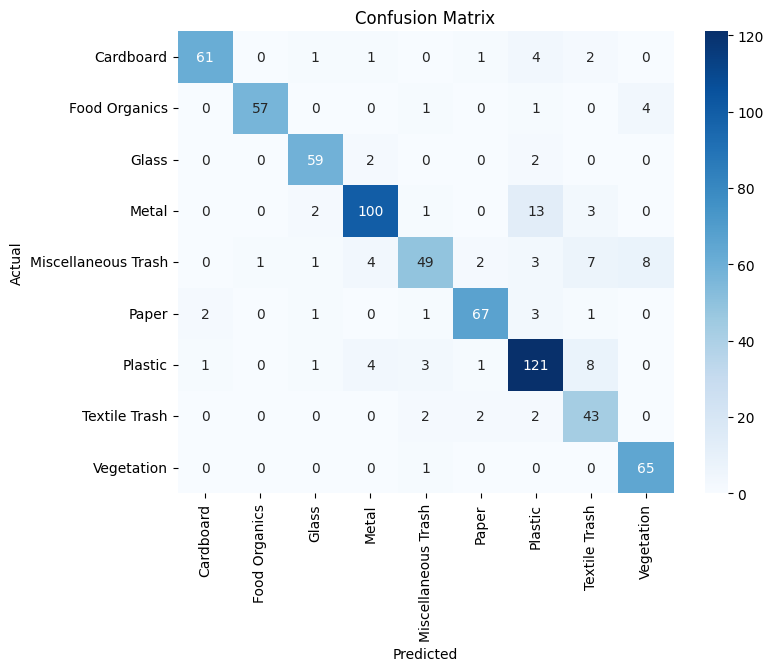


--- SGD Optimizer ---


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.76      0.96      0.85        70
      Food Organics       0.98      0.86      0.92        63
              Glass       0.83      0.84      0.83        63
              Metal       0.91      0.78      0.84       119
Miscellaneous Trash       0.66      0.73      0.70        75
              Paper       0.86      0.79      0.82        75
            Plastic       0.78      0.91      0.84       139
      Textile Trash       0.95      0.37      0.53        49
         Vegetation       0.84      0.97      0.90        66

           accuracy                           0.82       719
          macro avg       0.84      0.80      0.80       719
       weighted avg       0.83      0.82      0.81       719



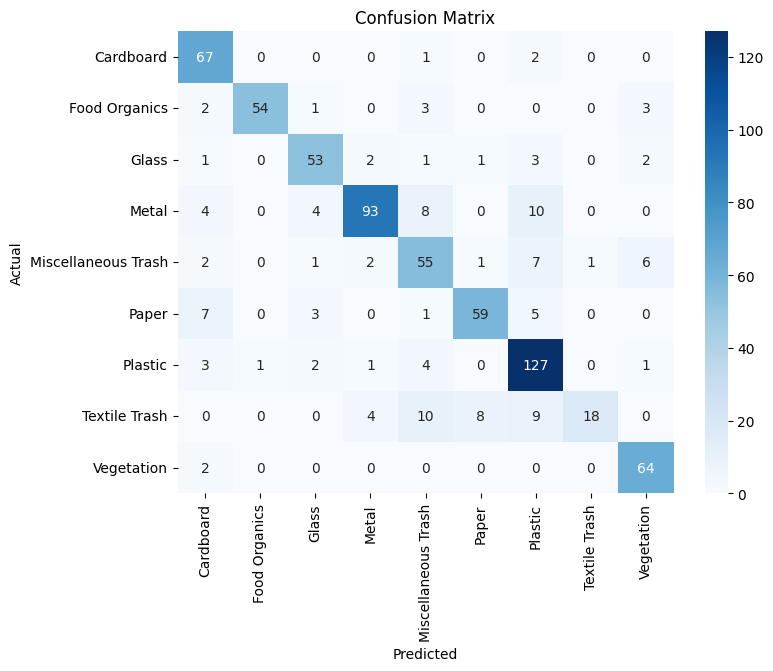


--- SGD with Momentum Optimizer ---


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.97      0.86      0.91        70
      Food Organics       0.94      0.94      0.94        63
              Glass       0.93      0.89      0.91        63
              Metal       0.90      0.87      0.89       119
Miscellaneous Trash       0.83      0.65      0.73        75
              Paper       0.93      0.87      0.90        75
            Plastic       0.83      0.93      0.88       139
      Textile Trash       0.73      0.90      0.81        49
         Vegetation       0.88      0.98      0.93        66

           accuracy                           0.88       719
          macro avg       0.88      0.88      0.88       719
       weighted avg       0.88      0.88      0.88       719



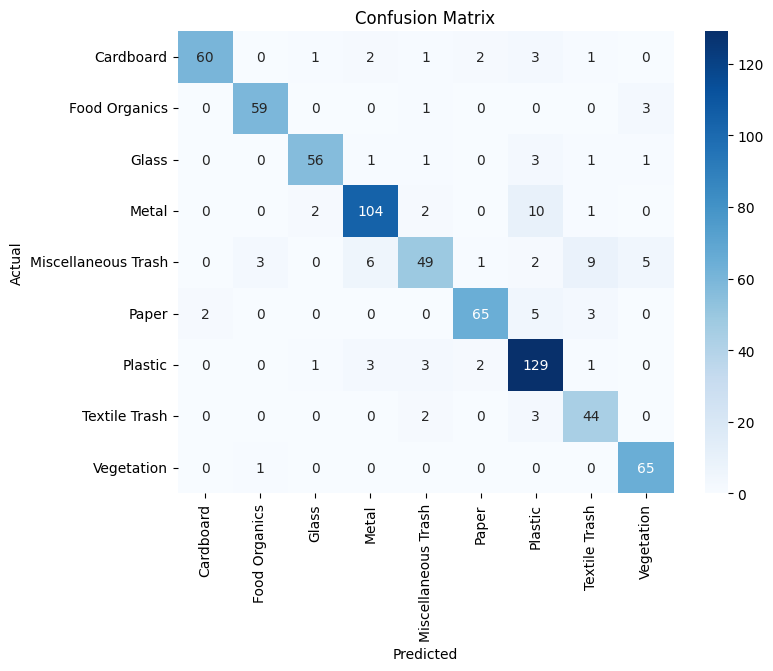

In [22]:
model_paths = {
    "Adam": "/kaggle/working/trained_Custom CNN_adam.pth",
    "SGD": "/kaggle/working/trained_Custom CNN_sgd.pth",
    "SGD with Momentum": "/kaggle/working/trained_Custom CNN_sgdmomentum.pth"
}

print("\n===== Detailed Test Evaluation for Each Optimizer =====\n")

for name, path in model_paths.items():
    print(f"\n--- {name} Optimizer ---\n")

    test_model = CNNModel(num_classes=9).to(device)
    test_model.load_state_dict(torch.load(path, map_location=device))

    evaluate_detailed(test_model, test_loader, classes)
